# Derivatives effect

Simulation of event related designs analyzed using HRF + derivatives
to show the effect of adding derivatives and also how parameter
estimate can change depending on the procedure.

The code calls `spm_get_bf.m` which is the [SPM](http://www.fil.ion.ucl.ac.uk/spm/)
function to obtain the hrf and derivatives. It also calls `spm_orth.m`
which is the orthogonalization procedure used in SPM. 

Finally, it calls `spm_orth2.m` which is a modification of `spm_orth.m` 
such as derivatives are orthogonalized against the hrf regressor and constant term together.

In [2]:
% when running localy
path_to_spm = '/home/remi/matlab/SPM/spm12/';
addpath(path_to_spm)

In [ ]:
clear all

Enter here the delay in seconds:
- 2 means the data peak later than expected
- -2 means the data peak earlier than expected

In [5]:
shift = 2; 

## HRF model using SPM function

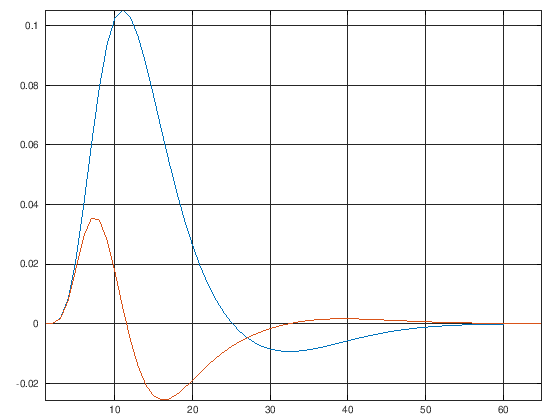

In [7]:
xBF.dt = 0.5;
xBF.name = 'hrf (with time derivative)';
xBF.length = 32;
xBF.order = 1;
xBF = spm_get_bf(xBF);

figure('Name','hrf model')
plot(xBF.bf,'LineWidth',3); 
axis tight; 
grid on;

## Compare data with / without temporal shift

### No temporal shift

#### Helper functions

In [13]:
function SS = compute_sum_of_squares(Y)
    SS = norm(Y - mean(Y)).^2;
end

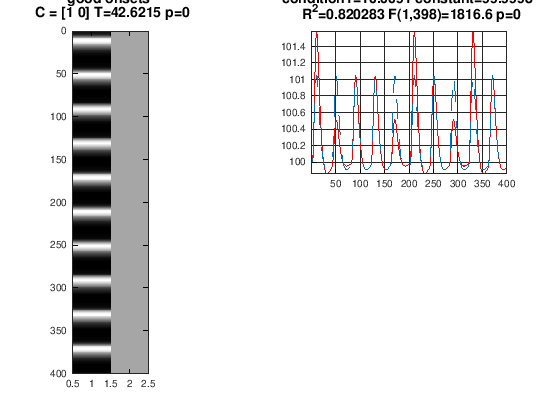

In [14]:
% height of the neural response
scale = [15 5 10 10 5 15 10 5 15 10];

onsets = 1:40:400;

% the data, 250 sec sample at 2Hz
Y1 = zeros(500, 1);

% the regressor of the matrix
X1 = zeros(500, 1);

for i = 1:10
    Y1(onsets(i)) = scale(i);
    X1(onsets(i)) = 1;
end

% super-sampled regressor
SS = conv(X1, spm_hrf(0.5));
% adjust length for simulation
X1 = [SS(1:400) ones(400, 1)];
% simulated signal
Y1 = conv(Y1, spm_hrf(0.5));
% adjust length for simulation
Y1 = Y1(1:400) + 100;

% sum of squares
SStotal = compute_sum_of_squares(Y1);

beta1 = pinv(X1) * Y1;
Yhat = X1 * beta1;
figure('Name', 'Fig. 4 Effect of temporal shift');

subplot(2, 4, [1 5]);
imagesc([zscore(X1(:, 1)) X1(:, 2)]);
colormap('gray');

subplot(2, 4, [3 4]);
hold on;
grid on;

plot(Y1, 'r', 'LineWidth', 3);
plot(Yhat, '--', 'LineWidth', 2);

axis tight;

% stats 1
SSeffect = compute_sum_of_squares(Yhat);
Residuals = Y1 - Yhat;
SSerror = compute_sum_of_squares(Residuals);
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y1) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', ...
                    beta1(1), ...
                    beta1(2), ...
                    R2, ...
                    df, ...
                    dfe, ...
                    F, ...
                    p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1);
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X1));
C = [1 0];
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X1)));
myrange(1) = range(X1(:, 1));
mytitle = sprintf('good onsets \n C = [1 0] T=%g p=%g', T_con, p_con);
subplot(2, 4, [1 5]);
title(mytitle, 'FontSize', 14);


### Shift the signal in time

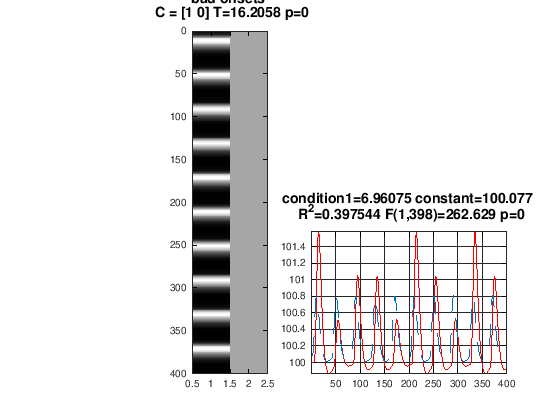

In [16]:
% 250 sec sample at 2Hz
Y1 = zeros(500, 1); 
X1 = zeros(500, 1);
for i = 1:10
    try
        Y1(onsets(i) + shift * 2) = scale(i); % shift
    catch
        Y1(onsets(i)) = scale(i); % no shift - occurs for neg value at Y(1)
    end
    X1(onsets(i)) = 1;
end

SS(:, 1) = conv(X1, xBF.bf(:, 1));
SS(:, 2) = conv(X1, xBF.bf(:, 2));
X1 = [SS(1:400, 1) ones(400, 1)];
Y1 = conv(Y1, spm_hrf(0.5));
Y1 = Y1(1:400) + 100;
SStotal = norm(Y1 - mean(Y1)).^2;

beta1 = pinv(X1) * Y1;
Yhat = X1 * beta1;
subplot(2, 4, [2 6]);
imagesc([zscore(X1(:, 1)) X1(:, 2)]);
colormap('gray');
subplot(2, 4, [7 8]);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y1) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta1(1), beta1(2), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1); % H matrix
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X1));
C = [1 0];
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X1)));
mytitle = sprintf('bad onsets \n C = [1 0] T=%g p=%g', T_con, p_con);
subplot(2, 4, [2 6]);
title(mytitle, 'FontSize', 14);


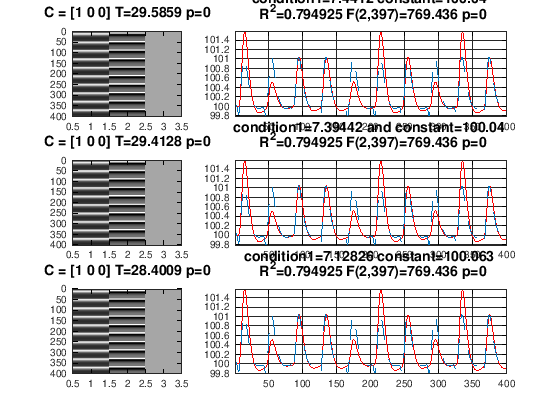

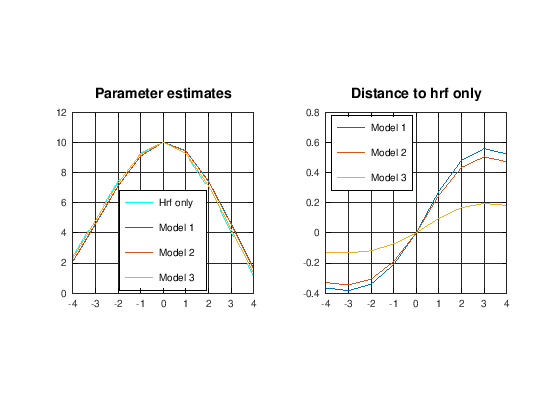

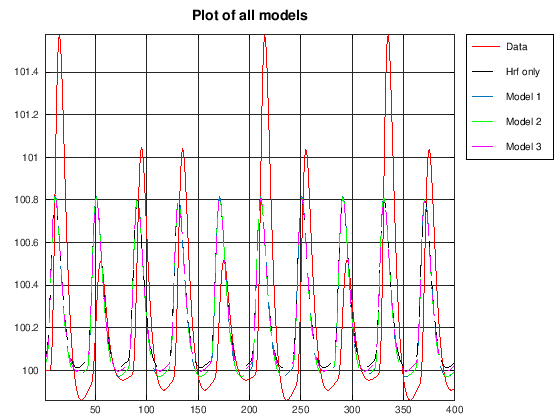

In [17]:

%% Model the time shifted signal using the 1st derivative
% --------------------------------------------------------

%%% _No orthogonalization_
% -----------------------
X2 = [SS(1:400, :) ones(400, 1)];
beta2 = pinv(X2) * Y1;
Yhat = X2 * beta2;
figure('Name', 'Fig. 5. Models with derivatives');
subplot(3, 3, 1);
imagesc([zscore(X2(:, 1:2)) X2(:, 3)]);
colormap('gray');
subplot(3, 3, [2 3]);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X2) - 1;
dfe = length(Y1) - rank(X2);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta2(1), beta2(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X2 * pinv(X2); % H matrix
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X2));
C = [1 0 0];
T_con = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X2)));
mytitle = sprintf('C = [1 0 0] T=%g p=%g', T_con, p_con);
subplot(3, 3, 1);
title(mytitle, 'FontSize', 14);

%%% _Derivative orthogonal to hrf regressor_
% --------------------------------------------
x = spm_orth(SS);
X3 = [x(1:400, :) ones(400, 1)];
beta3 = pinv(X3) * Y1;
Yhat = X3 * beta3;
Hrf_time_derv2 = Yhat;
subplot(3, 3, 4);
imagesc([zscore(X3(:, 1:2)) X3(:, 3)]);
colormap('gray');
subplot(3, 3, [5 6]);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X3) - 1;
dfe = length(Y1) - rank(X3);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g and constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta3(1), beta3(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X3 * pinv(X3); % H matrix
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X3));
C = [1 0 0];
T_con = (C * beta3) ./ sqrt(variance .* (C * pinv(X3' * X3) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X3)));
mytitle = sprintf('C = [1 0 0] T=%g p=%g', T_con, p_con);
subplot(3, 3, 4);
title(mytitle, 'FontSize', 14);

%%% _Derivative orthogonal to [hrf regressor constant]_
% ----------------------------------------------------
x = spm_orth2(SS);
X4 = [x(1:400, :) ones(400, 1)];
beta4 = pinv(X4) * Y1;
Hrf_time_derv3 = Yhat;
subplot(3, 3, 7);
imagesc([zscore(X4(:, 1:2)) X4(:, 3)]);
colormap('gray');
subplot(3, 3, [8 9]);
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(Yhat, '--', 'LineWidth', 2);
grid on;
axis tight;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
Residuals = Y1 - Yhat;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X4) - 1;
dfe = length(Y1) - rank(X4);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta4(1), beta4(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X4 * pinv(X4); % H matrix
R = eye(size(Y1, 1)) - P;
variance = ((R * Y1)' * (R * Y1)) / (size(Y1, 1) - rank(X4));
C = [1 0 0];
T_con = (C * beta4) ./ sqrt(variance .* (C * pinv(X4' * X4) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y1, 1) - rank(X4)));
mytitle = sprintf('C = [1 0 0] T=%g p=%g', T_con, p_con);
subplot(3, 3, 7);
title(mytitle, 'FontSize', 14);

% additional figures to look at the hrf fit
figure('Name', 'hrf+derivative fit');
plot(Y1, 'r', 'LineWidth', 3);
grid on;
axis tight;
hold on;
plot(X1 * beta1, 'k--', 'LineWidth', 2);
grid on;
axis tight;
plot(X2(:, [1 3]) * beta2([1 3]), '--', 'LineWidth', 2);
grid on;
axis tight;
plot(X3(:, [1 3]) * beta3([1 3]), '--g', 'LineWidth', 2);
grid on;
axis tight;
plot(X4(:, [1 3]) * beta4([1 3]), '--m', 'LineWidth', 2);
grid on;
axis tight;
legend('Data', 'Hrf only', 'Model 1', 'Model 2', 'Model 3', 'Location', 'NorthEastOutside');
title('Plot of all models', 'FontSize', 14);

%% redo the above analyses to look at the effect on parameter estimates

%%% _Shift the signal in time in a continuous fashion_
% -----------------------------------------------------

index = 1;
for shift = -4:4

    Y1 = zeros(500, 1); % 250 sec sample at 2Hz
    X1 = zeros(500, 1);
    for i = 1:10
        try
            Y1(onsets(i) + shift * 2) = scale(i); % shift
        catch
            Y1(onsets(i)) = scale(i); % no shift - occurs for neg value at Y(1)
        end
        X1(onsets(i)) = 1;
    end

    SS(:, 1) = conv(X1, xBF.bf(:, 1));
    SS(:, 2) = conv(X1, xBF.bf(:, 2));
    X1 = [SS(1:400, 1) ones(400, 1)];
    Y1 = conv(Y1, spm_hrf(0.5));
    Y1 = Y1(1:400) + 100;
    beta1 = pinv(X1) * Y1;
    hrf(1, index) = beta1(1);
    % No orthogonalization
    X2 = [SS(1:400, :) ones(400, 1)];
    beta2 = pinv(X2) * Y1;
    hrf(2, index) = beta2(1);
    % Derivative orthogonal to hrf regressor
    x = spm_orth(SS);
    X3 = [x(1:400, :) ones(400, 1)];
    beta3 = pinv(X3) * Y1;
    hrf(3, index) = beta3(1);
    % Derivative orthogonal to [hrf regressor constant]
    x = spm_orth2(SS);
    X4 = [x(1:400, :) ones(400, 1)];
    beta4 = pinv(X4) * Y1;
    hrf(4, index) = beta4(1);

    % update index
    index = index + 1;
end

figure('Name', 'Hrf estimates per orthogonalization procedure');
subplot(1, 2, 1);
plot([-4:4], hrf(1, :), 'c--', 'LineWidth', 3);
hold on;
plot([-4:4], hrf([2 3 4], :), 'LineWidth', 3);
axis square;
grid on;
legend('Hrf only', 'Model 1', 'Model 2', 'Model 3', 'Location', 'South');
title('Parameter estimates', 'FontSize', 14);
subplot(1, 2, 2);
D = [[hrf(2, :) - hrf(1, :)]; [hrf(3, :) - hrf(1, :)]; [hrf(4, :) - hrf(1, :)]];
plot([-4:4], D, 'LineWidth', 3);
axis square;
grid on;
legend('Model 1', 'Model 2', 'Model 3', 'Location', 'NorthWest');
title('Distance to hrf only', 'FontSize', 14);
